In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, MaxPooling1D, GlobalMaxPooling1D,Bidirectional
from keras.layers.convolutional import Conv1D 
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import json
file = open("data_file_2L.json", 'r')
json_data = json.load(file)
merged_dict = {}
for dictionary in json_data:
    for key, value in dictionary.items():
        if key not in merged_dict:
            merged_dict[key] = []
        merged_dict[key].append(value)
file.close()

In [3]:
# data
all_texts = [value for values in merged_dict.values() for value in values]

# labels
lengths_list = [len(values) for values in merged_dict.values()]
all_labels=[]
for i in range(0,len(lengths_list)):
    all_labels += [i] * lengths_list[i]

In [4]:
# Tokenizing the texts
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(all_texts)
sequences = tokenizer.texts_to_sequences(all_texts)


In [5]:
# Pading the sequences
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [6]:
# Converting the labels to one-hot encoding
num_classes = len(np.unique(all_labels))
one_hot_labels = to_categorical(all_labels, num_classes=num_classes)

In [7]:
# Calculate the number of data points per label
num_labels = one_hot_labels.shape[1]
num_points_per_label = np.sum(one_hot_labels, axis=0)

# Calculate the number of data points for each set
total_size = np.sum(num_points_per_label)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Create empty arrays to hold the indices for each set
train_indices = []
val_indices = []
test_indices = []

# Loop through each label and divide the indices into the sets
for label in range(num_labels):
    # Get the indices for the current label
    label_indices = np.where(one_hot_labels[:, label] == 1)[0]

    # Shuffle the indices
    np.random.shuffle(label_indices)

    # Divide the indices into the sets
    num_train_points = int(num_points_per_label[label] * 0.6)
    num_val_points = int(num_points_per_label[label] * 0.2)
    num_test_points = num_points_per_label[label] - num_train_points - num_val_points

    train_indices.extend(label_indices[:num_train_points])
    val_indices.extend(label_indices[num_train_points:num_train_points+num_val_points])
    test_indices.extend(label_indices[num_train_points+num_val_points:num_train_points+num_val_points+int(num_test_points)])

# Use the indices to extract the sequences and labels for each set
train_sequences = padded_sequences[np.array(train_indices)]
train_labels = one_hot_labels[np.array(train_indices)]
val_sequences = padded_sequences[np.array(val_indices)]
val_labels = one_hot_labels[np.array(val_indices)]
test_sequences = padded_sequences[np.array(test_indices)]
test_labels = one_hot_labels[np.array(test_indices)]

In [8]:
# Calculating the class weights
class_weights = dict(zip(np.unique(all_labels), compute_class_weight(class_weight = "balanced", classes = np.unique(all_labels), y = all_labels)))

In [9]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=400, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Training the model
if len(class_weights) > 0:
    history = model.fit(train_sequences, train_labels, validation_data = (val_sequences,val_labels), epochs=10, batch_size=64, class_weight=class_weights)
else:
    history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=10, batch_size=64) 



Epoch 1/10
23078/23078 [==============================] - 39138s 2s/step - loss: 0.0635 - accuracy: 0.9795 - val_loss: 0.0209 - val_accuracy: 0.9941
Epoch 2/10
23078/23078 [==============================] - 38973s 2s/step - loss: 0.0199 - accuracy: 0.9940 - val_loss: 0.0202 - val_accuracy: 0.9943
Epoch 3/10
23078/23078 [==============================] - 38699s 2s/step - loss: 0.0185 - accuracy: 0.9942 - val_loss: 0.0216 - val_accuracy: 0.9943
Epoch 4/10
23078/23078 [==============================] - 38726s 2s/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.0226 - val_accuracy: 0.9943
Epoch 5/10
23078/23078 [==============================] - 38776s 2s/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 0.0226 - val_accuracy: 0.9943
Epoch 6/10
23078/23078 [==============================] - 38923s 2s/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 0.0208 - val_accuracy: 0.9943
Epoch 7/10
23078/23078 [==============================] - 38848s 2s/step - loss: 0.0177 - accuracy: 0.9943

In [12]:
# Save Model and Weights
model.save('Bi-LSTM.h5')
model.save_weights('Bi-LSTM.hdf5')

In [13]:
# Load saved model
model = models.load_model('Bi-LSTM.h5')

In [14]:
# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_sequences, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

15386/15386 [==============================] - 362s 23ms/step - loss: 0.0244 - accuracy: 0.9942
Test loss: 0.024376286193728447
Test accuracy: 0.9941603541374207


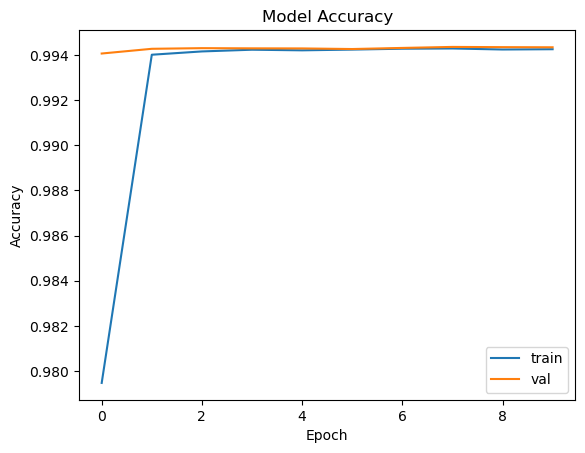

In [15]:
import matplotlib.pyplot as plt
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

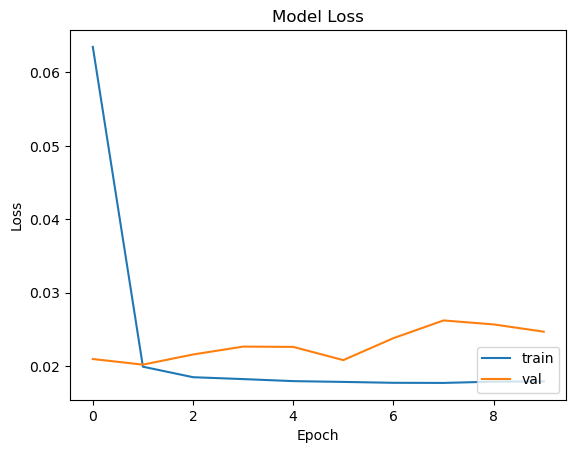

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [17]:
y_pred = model.predict(test_sequences, 64)

7693/7693 [==============================] - 217s 28ms/step


In [18]:
predicted_labels = np.argmax(y_pred, axis=1)

In [19]:
actual_labels = np.argmax(test_labels, axis=1)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
# Get the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Print the classification report
print(classification_report(actual_labels, predicted_labels))

# Print the confusion matrix
print("Confusion Matrix:")
print(np.array2string(cm, separator=', '))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40000
           1       1.00      1.00      1.00     37594
           2       1.00      1.00      1.00     33883
           3       0.96      0.99      0.97     33883
           4       1.00      0.95      0.97     33883
           5       1.00      1.00      1.00     29850
           6       1.00      1.00      1.00     27831
           7       1.00      1.00      1.00     37873
           8       1.00      1.00      1.00     40000
           9       1.00      1.00      1.00     21226
          10       1.00      1.00      1.00     38715
          11       0.97      1.00      0.99     38719
          12       1.00      0.98      0.99     39743
          13       1.00      1.00      1.00     39122

    accuracy                           0.99    492322
   macro avg       0.99      0.99      0.99    492322
weighted avg       0.99      0.99      0.99    492322

Confusion Matrix:
[[40000

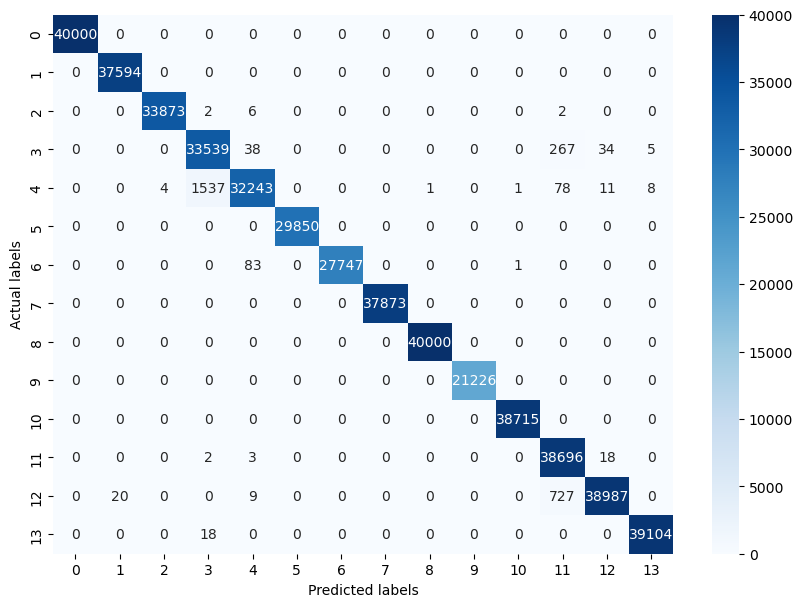

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [22]:
import xlsxwriter

# dictionary mapping labels to their respective text values
label2text = {0: "Date", 1: "Name Prefix", 2: "fullName", 3: "firstName", 4: "lastName", 5: "SNN", 6: "Contact Number", 7: "Email-ID", 8: "Gender", 9: "streetAddress", 10: "zipCode", 11: "City", 12: "State", 13: "Country"}

# Convert numeric class labels to text labels
expected_texts = [label2text[label] for label in actual_labels]
predicted_texts = [label2text[label] for label in predicted_labels]

# Create a new Excel workbook and add a worksheet
workbook = xlsxwriter.Workbook('Bi-LSTMPredictions.xlsx')
worksheet = workbook.add_worksheet()

# Add headers to the worksheet
worksheet.write('A1', 'Input Text')
worksheet.write('B1', 'Expected')
worksheet.write('C1', 'Predicted')

# Write the input text, expected, and predicted values to the worksheet
for i in range(len(test_sequences)):
    input_text = tokenizer.sequences_to_texts([test_sequences[i]])[0]
    expected_value = expected_texts[i]
    predicted_value = predicted_texts[i]
    worksheet.write(i+1, 0, input_text)
    worksheet.write(i+1, 1, expected_value)
    worksheet.write(i+1, 2, predicted_value)

# Close the workbook
workbook.close()

In [23]:
confidence_scores = np.max(y_pred, axis=1)

In [24]:
# Print predicted labels and confidence scores
def output_pred(x,y):
    for label, score in zip(x, y):
        if label == 0:
            print("The model predicts the input text to be --->Date")
        elif label == 1:
            print("The model predicts the input text to be --->Prefix")
        elif label == 2:
            print("The model predicts the input text to be --->fullName")
        elif label == 3:
            print("The model predicts the input text to be --->firstName")
        elif label == 4:
            print("The model predicts the input text to be --->lastName")
        elif label == 5:
            print("The model predicts the input text to be --->SNN")
        elif label == 6:
            print("The model predicts the input text to be --->ContactNumber")
        elif label == 7:
            print("The model predicts the input text to be --->Email-ID")
        elif label == 8:
            print("The model predicts the input text to be --->Gender")
        elif label == 9:
            print("The model predicts the input text to be --->streetAddress")
        elif label == 10:
            print("The model predicts the input text to be --->zipCode")
        elif label == 11:
            print("The model predicts the input text to be --->City")
        elif label == 12:
            print("The model predicts the input text to be --->State")
        elif label == 13:
            print("The model predicts the input text to be --->Country")
        print("with a confidence score of:", score)

In [25]:
# Testcase
# Tokenize new texts
new_texts = ["Georgia"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)

# Make predictions on new texts and calculate confidence scores
predictions = model.predict(new_padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)
output_pred(predicted_labels,confidence_scores)

1/1 [==============================] - 0s 18ms/step
The model predicts the input text to be --->State
with a confidence score of: 0.9998367
